## Calculate pCO2 Residual in SOCAT sampling dataset

In [1]:
# created by Val Bennington
# May 2021

# Use SOCAT observations of pCO2 (already converted from fugacity)
# Use local long term mean pCO2 (from Takahashi's data centered on year 2000)
# Use satellite NOAA OI SST (all times, all locations)
# Calculate pCO2_Temperature (pCO2_T) at all times, locations using mean pCO2 and satellite SST
# When and where we have surface ocean pCO2 observations, calculate pCO2_Residual = pCO2 - pCO2_Temperature

# Examine what pCO2 and pCO2_Residual look like in space and as distributions
# Write out netcdf file of the pCO2_Residual with important other variables

In [1]:
# Modules
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import cmocean as cm            # really nice colorbars
%matplotlib inline

In [2]:
# For nice global ocean map:
%run _Val_Mapping.ipynb

In [3]:
# Doesn't change:
cmap = cm.cm.balance

## 0) Function needed to calculate pCO2_T:

In [4]:
def calc_pCO2T(pco2_mean,sst_series):
    
    # Use long term mean pCO2, time varying SST, and local long term mean SST to calculate pCO2_T
    pCO2_T = pco2_mean * np.exp(0.0423* (sst_series - sst_series.mean("time")))  # Takahashia et al, 2004

    pCO2_T = pCO2_T.transpose("time","ylat","xlon")  # Confirming order of dimensions for function output
     
    return pCO2_T

## 1) Load Mean pCO2 (Takahashi, centered on year 2000)

In [5]:
mean_dir = "/data/artemis/workspace/vbennington/Takahashi"
flnm = f"{mean_dir}/Takahashi_mean_pCO2_2D_mon_1x1_2000.nc"
taka = xr.load_dataset(f"{flnm}")
# variable pCO2_mean
pCO2_mean = taka.pCO2_mean
pCO2_mean #check dims

<xarray.DataArray 'pCO2_mean' (ylat: 180, xlon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * ylat     (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * xlon     (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

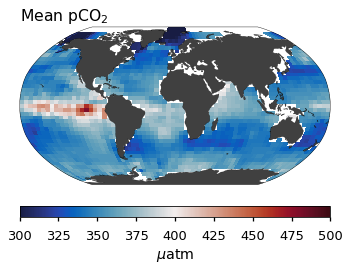

In [6]:
fig_shape = (1,1)
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(6,3.5))

    ### Create Figure:
    dia = SpatialMap2(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
    # Subplot 1: pCO2_Mean:
    vrange = [300, 500]
    sub = dia.add_plot(lat = pCO2_mean.ylat, 
                           lon = pCO2_mean.xlon, 
                           data = pCO2_mean, 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=0)
    dia.set_title(f"Mean pCO$_2$", 0, loc="left")
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, f"$\mu$atm")

## 2) Load Satellite SST (NOAA OISST)

In [7]:
# Load Satellite SST
sat_fname = "/data/artemis/workspace/vbennington/NOAA_SST/processed/SST_mon_198201-202012.nc"
sst_series = xr.open_dataset(f"{sat_fname}").sst
sst_series #check dims

<xarray.DataArray 'sst' (time: 468, ylat: 180, xlon: 360)>
[30326400 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2020-12-15
  * ylat     (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * xlon     (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

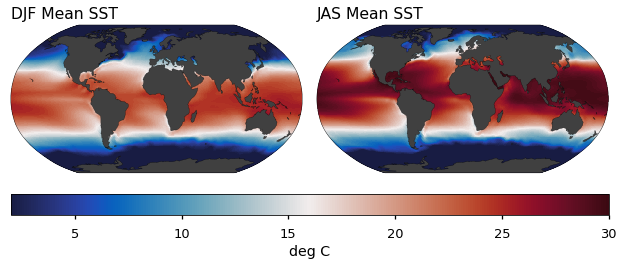

In [8]:
fig_shape = (1,2)
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(12,3.5))

    ### Create Figure:
    dia = SpatialMap2(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
   # Subplot 1: Mean SST DJF
    vrange = [2, 35]
    sub = dia.add_plot(lat = sst_series.ylat, 
                           lon = sst_series.xlon, 
                           data = sst_series.groupby("time.month").mean("time").sel(month=[12,1,2]).mean("month"), 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=0)
    dia.set_title(f"DJF Mean SST", 0, loc="left")
    
    # Subplot 1: Mean SST JAS
    vrange = [2, 30]
    sub = dia.add_plot(lat = sst_series.ylat, 
                           lon = sst_series.xlon, 
                           data = sst_series.groupby("time.month").mean("time").sel(month=[7,8,9]).mean("month"), 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=1)
    dia.set_title(f"JAS Mean SST", 1, loc="left")
    
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, f"deg C")

## 3) Calculate pCO2_T from SST and Mean pCO2

In [9]:
# Calculate pCO2-T from mean pCO2 and SST
pCO2_T = calc_pCO2T(pCO2_mean,sst_series)

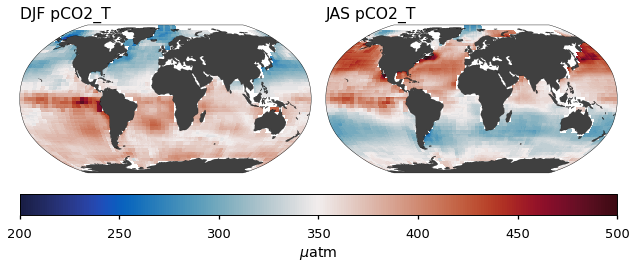

In [10]:
fig_shape = (1,2)
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(12,3.5))

    ### Create Figure:
    dia = SpatialMap2(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')

    # Subplot 1: pCO2_T in DJF
    vrange = [200, 500]
    sub = dia.add_plot(lat = pCO2_T.ylat, 
                           lon = pCO2_T.xlon, 
                           data = pCO2_T.groupby("time.month").mean("time").sel(month=[12,1,2]).mean("month"), 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=0)
    dia.set_title(f"DJF pCO2_T", 0, loc="left")
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, f"$\mu$atm")
    
    # Subplot 2: pCO2_T in JAS
    sub = dia.add_plot(lat = pCO2_T.ylat, 
                           lon = pCO2_T.xlon, 
                           data = pCO2_T.groupby("time.month").mean("time").sel(month=[9]).mean("month"), 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=1)
    dia.set_title(f"JAS pCO2_T", 1, loc="left")
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, f"$\mu$atm")
  

## 4) Load Observations of pCO2 (SOCAT, version 2021)

In [11]:
socat_dir = "/data/artemis/workspace/vbennington/SOCAT/processed"
socat_fname = f"{socat_dir}/SOCATv2021_pCO2_gridded_monthly_satelliteSST.nc"
socat_pco2 = xr.open_dataset(f"{socat_fname}").pco2  # units of uatm
socat_pco2 #check dims

<xarray.DataArray 'pco2' (time: 468, ylat: 180, xlon: 360)>
[30326400 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2020-12-15
  * ylat     (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * xlon     (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

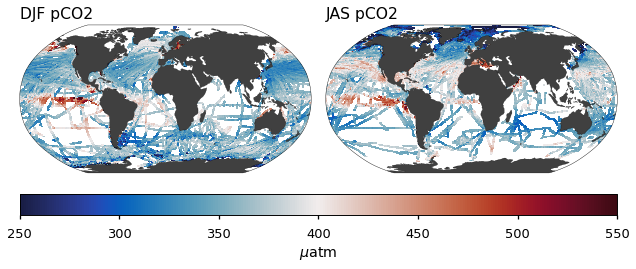

In [41]:
fig_shape = (1,2)
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(12,3.5))

    ### Create Figure:
    dia = SpatialMap2(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')

    # Subplot 1: socat_pco2 in DJF
    vrange = [250, 550]
    sub = dia.add_plot(lat = socat_pco2.ylat, 
                           lon = socat_pco2.xlon, 
                           data = socat_pco2.groupby("time.month").mean("time").sel(month=[12,1,2]).mean("month"), 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=0)
    dia.set_title(f"DJF pCO2", 0, loc="left")
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, f"$\mu$atm")
    
    # Subplot 2: socat_pco2 in JAS
    sub = dia.add_plot(lat = socat_pco2.ylat, 
                           lon = socat_pco2.xlon, 
                           data = socat_pco2.groupby("time.month").mean("time").sel(month=[7,8,9]).mean("month"), 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=1)
    dia.set_title(f"JAS pCO2", 1, loc="left")
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, f"$\mu$atm")

In [12]:
# Check range of SOCAT pCO2 for open ocean data:

print(socat_pco2.max())
print(socat_pco2.min())

# We know that in open ocean this should only be between 200 and 700:
socat_pco2 = socat_pco2.where(((socat_pco2 > 200) & (socat_pco2 < 700)))

print(socat_pco2.max())
print(socat_pco2.min())

<xarray.DataArray 'pco2' ()>
array(4324.0350177)
<xarray.DataArray 'pco2' ()>
array(44.67453378)
<xarray.DataArray 'pco2' ()>
array(699.68972693)
<xarray.DataArray 'pco2' ()>
array(200.01126099)


## 5) pCO2_Residual = pCO2 (observed) - pCO2_T (calculated)

In [13]:
pCO2_Residual = socat_pco2 - pCO2_T

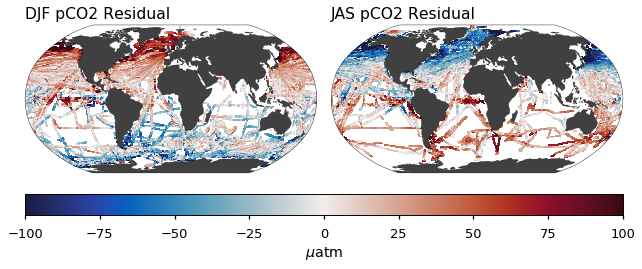

In [40]:
# What does the residual look like?

fig_shape = (1,2)
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(12,3.5))

    ### Create Figure:
    dia = SpatialMap2(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')

    # Subplot 1: pCO2_Residual in DJF
    vrange = [-100, 100]
    sub = dia.add_plot(lat = pCO2_Residual.ylat, 
                           lon = pCO2_Residual.xlon, 
                           data = pCO2_Residual.groupby("time.month").mean("time").sel(month=[12,1,2]).mean("month"), 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=0)
    dia.set_title(f"DJF pCO2 Residual", 0, loc="left")
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, f"$\mu$atm")
    
    # Subplot 2: pCO2_Residual in JAS
    sub = dia.add_plot(lat = pCO2_Residual.ylat, 
                           lon = pCO2_Residual.xlon, 
                           data = pCO2_Residual.groupby("time.month").mean("time").sel(month=[7,8,9]).mean("month"), 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=1)
    dia.set_title(f"JAS pCO2 Residual", 1, loc="left")
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, f"$\mu$atm")

# Examine Distributions compared to SOCAT pCO2

## How are these Distributed? (Ranges)

In [14]:
Resid_stack = pCO2_Residual.stack(z=('time','ylat','xlon'))
Resid_reduced = Resid_stack[~np.isnan(Resid_stack)]

In [15]:
pCO2_stack = socat_pco2.stack(z=('time','ylat','xlon'))
pCO2_reduced = pCO2_stack[~np.isnan(pCO2_stack)]

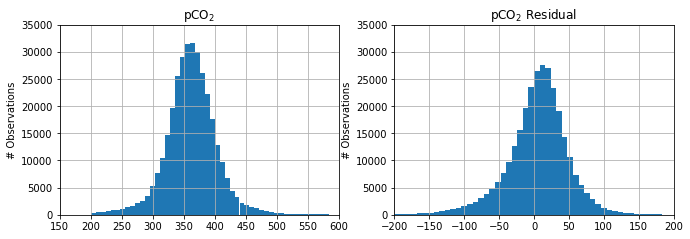

In [16]:
# Histogram of both of these:

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(11,3.5))
ax[0].hist(pCO2_reduced,50,[200,600])
ax[0].grid(True)
ax[0].set_ylabel("# Observations")
ax[0].set_title(f"pCO$_2$")
ax[0].set_xlim(150,600)
ax[0].set_ylim(0,35000)

ax[1].hist(Resid_reduced,50,[-200,200])
ax[1].grid(True)
ax[1].set_ylabel("# Observations")
ax[1].set_title(f"pCO$_2$ Residual")
ax[1].set_xlim(-200,200)
ax[1].set_ylim(0,35000)


plt.show()

# Across Space on the Mean?


/home/vbennington/.conda/envs/dev2/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


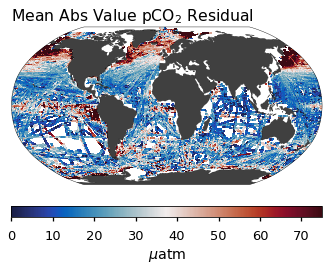

In [17]:
fig_shape = (1,1)
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(6,3.5))

    ### Create Figure:
    dia = SpatialMap2(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
    # Subplot 1: pCO2_Mean:
    vrange = [0, 75]
    sub = dia.add_plot(lat = pCO2_mean.ylat, 
                           lon = pCO2_mean.xlon, 
                           data = np.nanmean(np.abs(pCO2_Residual),axis=0), 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=0)
    dia.set_title(f"Mean Abs Value pCO$_2$ Residual", 0, loc="left")
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, f"$\mu$atm")

# Write out file to include SST, pCO2, pCO2_T, and pCO2_Residual

In [57]:
# Write out a file:

fout = f"{socat_dir}/SOCAT_Takahashi_pCO2_pCO2T_pCO2Resid_2D_mon_1x1_198201-202012.nc"

s_out = xr.Dataset(
                        {'SST':(['time','ylat','xlon'],sst_series),
                        'pCO2_T':(["time","ylat","xlon"],pCO2_T),
                        'pCO2_Residual':(["time","ylat","xlon"],pCO2_Residual),
                        'pCO2':(["time","ylat","xlon"],socat_pco2),
                        'pCO2_mean':(["ylat","xlon"],pCO2_mean)    
                        },
                        coords={'time':(['time'],pCO2_T.time),
                               'ylat':(['ylat'],pCO2_T.ylat),
                               'xlon':(['xlon'],pCO2_T.xlon)
                               })

# Description of each variable:
s_out.SST.attrs['description'] = 'SST from NOAA OI SST'
s_out.pCO2_T.attrs['description'] = 'pCO2_T calculated from NOAA OI SST and Mean pCO2 (Takahashi 2000)'
s_out.pCO2.attrs['description'] = 'SOCAT v2021 pCO2, limited to range of 200-700'
s_out.pCO2_mean.attrs['description'] = 'Mean pCO2 from Takahashi, centered on year 2000'
s_out.pCO2_Residual.attrs['description'] = 'Residual calculated as SOCAT pCO2 - pCO2_T'

# Units:
s_out.SST.attrs['units'] = 'deg C'
s_out.pCO2_T.attrs['units'] = 'uatm'
s_out.pCO2_Residual.attrs['units'] = 'uatm'
s_out.pCO2.attrs['units'] = 'uatm'
s_out.pCO2_mean.attrs['units'] = 'uatm'

# File attributes:
s_out.attrs['created by'] = 'Val Bennington, 00_calc_pCO2_residual.ipynb'
s_out.attrs['created date'] = str(datetime.date.today())

# Write out file:
s_out.to_netcdf(fout)